In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pmdarima import auto_arima
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from model_plots import TS_plot_actuals_vs_predicted,residual_plot
from model_metrics import get_model_metrics,get_data_stats
import preprocessing
import model_metrics

## Create aggregated sales

In [16]:
def create_aggregated():
    df = pd.read_csv('../Output Files/2020_2025_Jan.csv')

    agg_trans = df.groupby(by=["Transaction Date","Store ID","Item ID"])[["Quantity", "Total Amount"]].sum().reset_index()
    agg_trans.to_csv("./aggregated_transactions.csv", index= False)

    store_daily = df.groupby(by=["Transaction Date","Store ID"])[[ "Total Amount"]].sum().reset_index()
    store_daily.to_csv("./store_daily_revenue.csv", index=  False)

    daily_df = df.groupby(by=["Transaction Date"])[[ "Total Amount"]].sum().reset_index()
    daily_df.to_csv("./daily_revenue.csv", index=  False)

    print("Aggregated dfs have been created")

## Daily Revenue Models - set date features

In [17]:
df = pd.read_csv("./daily_revenue.csv")
df = df.rename(columns={"Transaction Date":"Date"})
df.rename(columns={'Total Amount': 'Revenue'}, inplace= True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
target = 'Revenue'
df = preprocessing.create_ts_features(df,'Date')
#df = preprocessing.add_lags(df, [1,7,30],target)



In [18]:
df

,Date,Revenue,Day_of_Week,Is_Weekend,Quarter,Month,Year,Day_of_Month,Week_of_year
0,2020-01-01,129258.43,2,0,1,1,2020,1,1
1,2020-01-02,141969.95,3,0,1,1,2020,2,1
2,2020-01-03,74025.44,4,0,1,1,2020,3,1
3,2020-01-04,112747.58,5,1,1,1,2020,4,1
4,2020-01-05,101970.57,6,1,1,1,2020,5,1
...,...,...,...,...,...,...,...,...,...
1852,2025-01-26,429100.11,6,1,1,1,2025,26,4
1853,2025-01-27,383833.45,0,0,1,1,2025,27,5
1854,2025-01-28,410080.63,1,0,1,1,2025,28,5
1855,2025-01-29,384074.44,2,0,1,1,2025,29,5


In [19]:
train_size = 0.70
train_df, test_df = train_test_split(df, test_size=1-train_size, shuffle=False)


X_train = train_df.drop(columns=[target, 'Date'])
y_train = train_df[target]
X_test = test_df.drop(columns=[target, 'Date'])
y_test = test_df[target]

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05)
model_xgb.fit(X_train, y_train)
predictions = model_xgb.predict(X_test)

metric_df = get_model_metrics(y_test,predictions)
print("XGBoost no CV:" )
display(metric_df)
test_stats_df = get_data_stats(y_test)
print("Test set stats") 
display(test_stats_df)
print(f"RMSE - STD: {(metric_df['RMSE'].values - test_stats_df['STD'].values)[0]} ")

print(f"Normalized RMSE = {model_metrics.normalized_rmse(metric_df['RMSE'][0],
                                                        test_stats_df['Min'][0],
                                                        test_stats_df['Max'][0])}") #Closer to 0 =

XGBoost no CV:


,RMSE,MAE,MAPE,R²,MSLE
0,79981.04,61886.7,16.32,-0.09,0.05


Test set stats


,Min,Max,Mean,Median,STD
0,192685.89,690826.51,353781.31,344343.26,76696.09


RMSE - STD: 3284.949999999997 
Normalized RMSE = 0.16


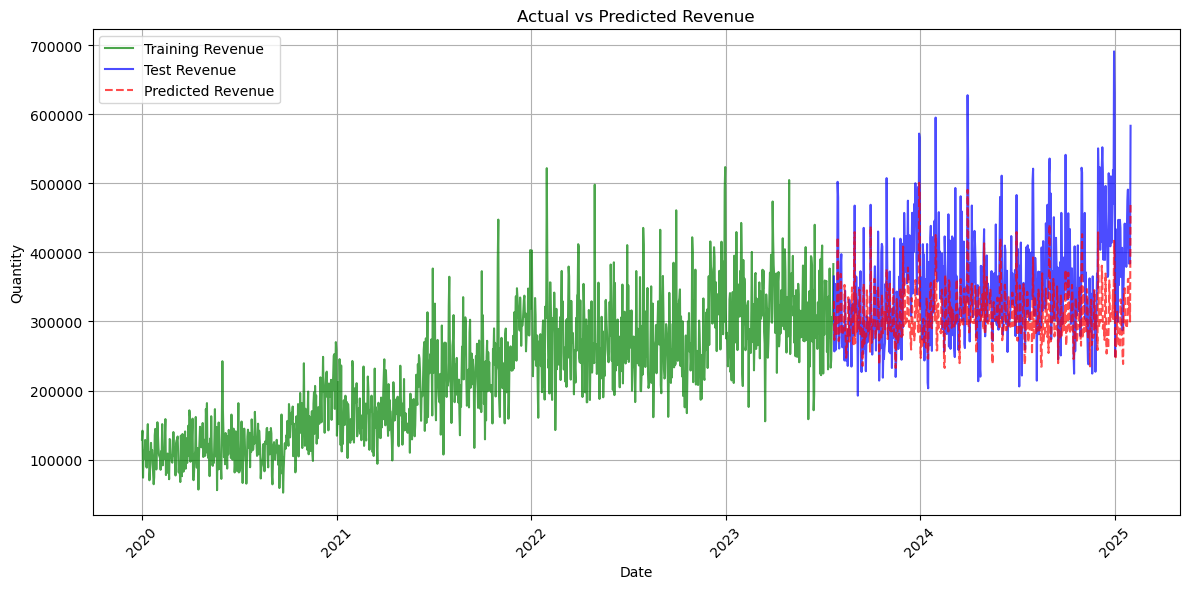

<Figure size 640x480 with 0 Axes>

In [20]:
plt.figure(figsize=(12, 6))

# Create a DataFrame for actual and predicted values
results_df = pd.DataFrame({
    'Date': test_df['Date'],  
    f'Actual {target}': y_test,
    f'Predicted {target}': predictions
})
pred_v_actual_plot = TS_plot_actuals_vs_predicted(train_df, results_df, target) 

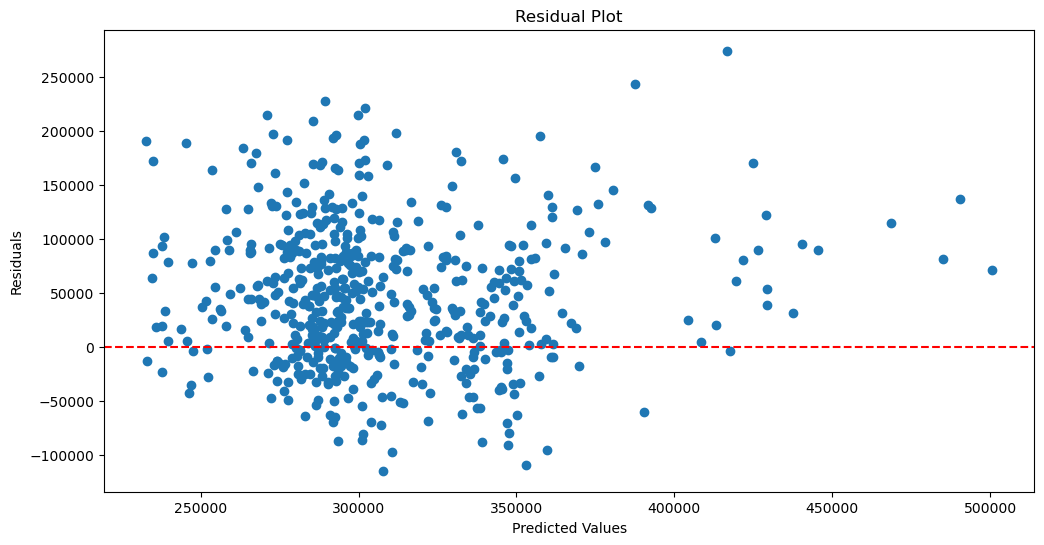

<Figure size 640x480 with 0 Axes>

In [21]:
plt.figure(figsize=(12, 6))
residual_plt = residual_plot(y_test, predictions) 

## With CV


In [22]:
param_grid = {
    'learning_rate': [ 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=tscv, 
                           verbose=1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_

# Predictions and Evaluation
pred_xgb_tuned = best_model.predict(X_test)

metric_df = get_model_metrics(y_test,pred_xgb_tuned)
print("XGBoost no CV:" )
display(metric_df)
test_stats_df = get_data_stats(y_test)
print("Test set stats") 
display(test_stats_df)
print(f"RMSE - STD: {(metric_df['RMSE'].values - test_stats_df['STD'].values)[0]} ")

print(f"Normalized RMSE = {model_metrics.normalized_rmse(metric_df['RMSE'][0],
                                                        test_stats_df['Min'][0],
                                                        test_stats_df['Max'][0])}") #Closer to 0 

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
XGBoost no CV:


,RMSE,MAE,MAPE,R²,MSLE
0,71715.27,55880.3,14.91,0.12,0.04


Test set stats


,Min,Max,Mean,Median,STD
0,192685.89,690826.51,353781.31,344343.26,76696.09


RMSE - STD: -4980.819999999992 
Normalized RMSE = 0.14


In [23]:
abs(test_stats_df['Mean'][0] - metric_df['MAE'][0])

297901.01

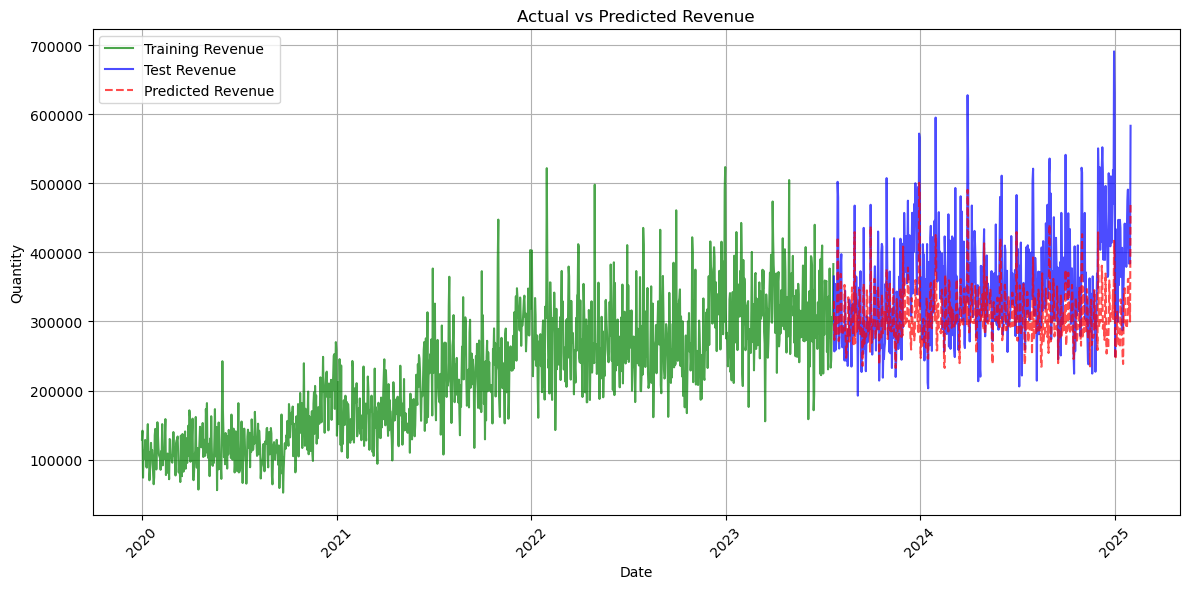

<Figure size 640x480 with 0 Axes>

In [24]:
plt.figure(figsize=(12, 6))

# Create a DataFrame for actual and predicted values
results_df = pd.DataFrame({
    'Date': test_df['Date'],  
    f'Actual {target}': y_test,
    f'Predicted {target}': predictions
})
pred_v_actual_plot = TS_plot_actuals_vs_predicted(train_df, results_df, target) 

In [25]:
import seaborn as sns

def plot_correlation_matrix(df):
    """
    Plots a heatmap of the correlation matrix for numerical features in a DataFrame.
    """
    numerical_df = df.select_dtypes(include=['number'])
    correlation_matrix = numerical_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

